In [1]:
import numpy as np
import pickle
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt
from numba import njit
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

___

Блок для ускорения критических модулей

In [2]:
@njit('i8[:](i8[:])', cache=True)
def availablePositions(board):
    data = np.where(board==0)
    return data[0]

In [3]:
@njit('i8[:](f4[:])', cache=True)
def availablePositionsF(board):
    data = np.where(board==0)
    return data[0]

In [4]:
@njit("f4[:](f4[:,:],f4[:,:])",cache=True)
def transform_state_to_action(matrix_output, batch_state):
        result = np.zeros(batch_state.shape[0],dtype=np.float32)
        for i in range(batch_state.shape[0]):
            ind = availablePositionsF(batch_state[i])
            if len(ind)>0:
                result[i] = np.max(matrix_output[i][ind])
            else:
                result[i] = np.max(matrix_output[i])
        return result

In [5]:
@njit('i8[:,:](i8)',cache=True)
def base_pattern(n_row):
    n_row2 = n_row<<1
    result = np.zeros((n_row2 + 2, n_row), dtype=np.int64)
    line_left = n_row2 - 4
    line_left2 = line_left>>1
    for i in range(n_row):
        result[0, i] = i 
        result[1, i] = i * n_row
        result[2, i] = i * (n_row + 1)
        result[3, i] = (i + 1) * n_row - 1
        result[4, i] = result[3, i] - i
        result[5, i] = n_row * (n_row - 1) + i
        for j in range(line_left2):
            result[6 + j, i] = result[3, i] - j - 1
            result[6 + line_left2 + j, i] = result[5, i] - n_row * (j + 1)
    return result

In [6]:
@njit('i8[:](i8[:], i8[:,:], i8, i8, i8)',cache=True)
def win_pattern_from_vector(board, pattern, board_rows, board_cols, num_counts):
    result = np.zeros(2, dtype=np.int64)
    for i in range(pattern.shape[0]):
        s = 0
        for j in range(pattern.shape[1]):
            s += board[pattern[i,j]]
        if s == num_counts:
            result[0] = 1
            result[1] = 1
            return result
        elif s == -num_counts:
            result[0] = 1
            result[1] = -1
            return result
    if len(availablePositions(board)) == 0:
        result[0] = 1
        result[1] = 0
        return result
    result[0] = 0
    result[1] = 0
    return result

___

In [7]:
class DQN(nn.Module):
    def __init__(self, size_deck, layer_size=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(size_deck, layer_size)
        self.l2 = nn.Linear(layer_size, size_deck)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [8]:
class DuelingDQN(nn.Module):
    def __init__(self, size_deck, layer_size=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(size_deck, layer_size)
        self.l2 = nn.Linear(layer_size, size_deck)
        self.l3 = nn.Linear(layer_size, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x1 = self.l2(x)
        x2 = self.l3(x)
        return x2 + (x1 - x1.mean())

In [9]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
    def replace_last_reward(self, tensor_new_reward):
        tmp = list(self.memory[-1])
        tmp[3] = tensor_new_reward
        self.memory[-1] = tuple(tmp)
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [10]:
class TicTacToe:
    def __init__(self, board_rows, board_cols, num_counts):
        self.board = np.zeros(board_rows * board_cols, dtype = int)
        self.isEnd = False
        self.playerName = 1
        self.board_rows = board_rows
        self.board_cols = board_cols
        self.num_counts = num_counts
        self.pattern = base_pattern(self.board_rows)
        
    def getHash(self):
        return self.board

    def winner(self):
        win = win_pattern_from_vector(self.board, self.pattern, self.board_rows, self.board_cols, self.num_counts)
        self.isEnd = win[0]
        if not self.isEnd:
            return None
        return win[1]
    
    def game_is_end(self):
        return self.isEnd
    
    def get_reward(self):
        win = self.winner()
        if not self.isEnd:
            return 0
        return win
    
    def updateState(self, position):
        self.board[position] = self.playerName
        self.playerName = -1 if self.playerName == 1 else 1
    
    def availablePositions(self):
        return availablePositions(self.board)
        
    def who_played(self):
        return self.playerName
    def bord_in_2d(self):
        return self.board.reshape((self.board_rows, self.board_cols))
    def reset(self):
        self.board = np.zeros(self.board_rows * self.board_cols, dtype = int)
        self.isEnd = False
        self.playerName = 1

In [11]:
class Player:
    def __init__(self, board_rows, board_cols, type_network="DQN",
                 lr=0.001, gamma=0.8, batch_size=64, counts_size_memory=10000):
        
        self.size_deck = board_cols * board_rows
        self.memory = ReplayMemory(counts_size_memory)
        
        if type_network == "DQN":
            self.model = DQN(size_deck=self.size_deck, layer_size=128)
        elif type_network == "DuelingDQN":
            self.model = DuelingDQN(size_deck=self.size_deck, layer_size=128)
            
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        
        self.steps_done = 0
        self.episode_durations = []
        self.num_step = 0
        
    def select_greedy_action(self, state_tensor, available_position):
        actions_tensor = self.model(state_tensor).view(-1)
        pos_max = actions_tensor[available_position].max(-1)[1].item()
        #print("out", torch.tensor([available_position[pos_max]], dtype=torch.int64))
        return torch.tensor([[available_position[pos_max]]], dtype=torch.int64)
    
    def select_random_action(self, available_position):
        return torch.tensor([[random.choice(available_position)]], dtype=torch.int64)
    
    def select_action(self, state_tensor, available_position):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state_tensor, available_position)
        else:
            return self.select_random_action(available_position)

In [12]:
class Solver():
    def __init__(self, p1, p2, board_rows, board_cols, num_counts, TEST=False):
        
        self.p1 = p1
        self.p2 = p2
        self.board = TicTacToe(board_rows, board_cols, num_counts)
        self.ep = 1
        self.TEST = TEST
    def _run_episode(self, do_learning=True, greedy=False):
        
        self.board.reset()
        state = self.board.getHash()
        done = False   
        tmp = 0
        while not done:
            if self.TEST:
                print("___P1____________________")
            # Player 1
            self.current_player = self.p1
            available_position = self.board.availablePositions()  
            state_tensor = torch.tensor([state], dtype=torch.float32)
            with torch.no_grad():
                if do_learning:
                    if greedy:
                        action_tensor = self.current_player.select_greedy_action(state_tensor, available_position)
                    else:
                        action_tensor = self.current_player.select_action(state_tensor, available_position)
                else:
                    if greedy:
                        action_tensor = self.current_player.select_greedy_action(state_tensor, available_position)
                    else:
                        action_tensor = self.current_player.select_action(state_tensor, available_position)

            self.board.updateState(action_tensor.numpy()[0][0])
            reward = self.board.get_reward()
            next_state = self.board.getHash()
            done = self.board.game_is_end()
            tmp +=1
            if do_learning:
                next_state_tensor = torch.tensor([next_state], dtype=torch.float32)
                if self.TEST:
                    print("state_tensor",state_tensor)
                    print("action_tensor",action_tensor)
                    print("next_state_tensor",next_state_tensor)
                    print("reward",torch.tensor([reward], dtype=torch.int32))
                transition = (state_tensor, 
                              action_tensor, 
                              next_state_tensor, 
                              torch.tensor([reward], dtype=torch.int32))
                
                if done:
                    self.p2.memory.replace_last_reward(torch.tensor([-1], dtype=torch.int32))
                self.current_player.memory.store(transition)
                if self.TEST:
                    print("___Память__p1\n",list(map(lambda x: x[3],self.current_player.memory.memory)))
                    print("___Память__p2\n",list(map(lambda x: x[3],self.p2.memory.memory)))

                self._learn()
            
            if done:
                if self.TEST:
                    print("{} из {}".format(tmp,9))
                    print("игра {}".format(self.ep))
                    print("winner =",self.board.winner())
                    print(self.board.bord_in_2d())
                self.ep+=1
                tmp = 0
                return reward
                
            else:
                if self.TEST:
                    print("___P2____________________")
                tmp +=1
                state = next_state
                # Player 2
                self.current_player = self.p2
                available_position = self.board.availablePositions()
                state_tensor = torch.tensor([state], dtype=torch.float32)
                with torch.no_grad():
                    if do_learning:
                        if greedy:
                            action_tensor = self.current_player.select_greedy_action(state_tensor, available_position)
                        else:
                            action_tensor = self.current_player.select_action(state_tensor, available_position)
                    else:
                        if greedy:
                            action_tensor = self.current_player.select_random_action(available_position)
                        else:
                            action_tensor = self.current_player.select_random_action(available_position)

                self.board.updateState(action_tensor.numpy()[0][0])
                reward = self.board.get_reward()
                next_state = self.board.getHash()
                done = self.board.game_is_end()
                
                if do_learning:
                        next_state_tensor = torch.tensor([next_state], dtype=torch.float32)
                        if self.TEST:
                            print("state_tensor",state_tensor)
                            print("action_tensor",action_tensor)
                            print("next_state_tensor",next_state_tensor)
                            print("reward",torch.tensor([-reward], dtype=torch.int32))
                        transition = (state_tensor, 
                                      action_tensor, 
                                      next_state_tensor, 
                                      torch.tensor([-reward], dtype=torch.int32))
                        if done:
                            self.p1.memory.replace_last_reward(torch.tensor([-1], dtype=torch.int32))
                        self.current_player.memory.store(transition)
                        if self.TEST:
                            print("___Память__p1\n",list(map(lambda x: x[3],self.p1.memory.memory)))
                            print("___Память__p2\n",list(map(lambda x: x[3],self.current_player.memory.memory)))

                        self._learn()

                if done:
                    if self.TEST:
                        print("{} из {}".format(tmp,9))
                        print("игра {}".format(self.ep))
                        print("winner =",self.board.winner())
                        print(self.board.bord_in_2d())
                    self.ep+=1
                    tmp = 0
                    return reward
                state = next_state

    def _learn(self):
        mem = self.current_player.memory
        if len(mem.memory) < self.current_player.batch_size:
            return
        if self.TEST:
            print("______________________learning______________________")
        # берём мини-батч из памяти
        
        transitions = mem.sample(self.current_player.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        if self.TEST:
            print("state\n",batch_state)
            print("reward\n",batch_reward)
            print("batch_next_state\n",batch_next_state)
        
        # считаем значения функции Q
        Q = self.current_player.model(batch_state).gather(1, batch_action).reshape([self.current_player.batch_size])
        
        # оцениваем ожидаемые значения после этого действия
        model_next_state = self.current_player.model(batch_next_state)
        
        Qmax = torch.tensor(transform_state_to_action(model_next_state.detach().numpy(), batch_next_state.detach().numpy()), dtype=torch.float32)
        Qnext = batch_reward + (self.current_player.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        self.current_player.optimizer.zero_grad()
        loss.backward()
        self.current_player.optimizer.step()
    
    def fit(self, episod_fit=1000, episod_validate=100, delta_validate=100):
        self._fig, self._ax = plt.subplots(nrows=2, figsize=(8,12))
        dict_data = {-1:[], 0:[], 1:[]}
        mean_data = []
        data_x = []
        
        for i in tqdm(range(episod_fit+1)):
            #Валидация
            if i%delta_validate == 0:
                mean, dict_res = self.validate(episod_validate, greedy=True)
                data_x.append(i)
                mean_data.append(mean)
                dict_data[1].append(dict_res[1])
                dict_data[0].append(dict_res[0])
                dict_data[-1].append(dict_res[-1])
                self._draw_plot(data_x, mean_data, dict_data[1], dict_data[0], dict_data[-1])
                
                print("Rounds {}, mean ={}, win = {}, draw = {}, loose = {}".format(i, 
                                                                                    mean, 
                                                                                    dict_res[1],
                                                                                    dict_res[0],
                                                                                    dict_res[-1]))
            #Обучение
            if i < episod_fit:
                if self.TEST:
                    print("_______________обучение__________________")
                self._run_episode(do_learning=True, greedy=False)
            
    def validate(self, episod_validate, greedy=True):
        if self.TEST:
            print("_______________валидация__________________")
        counts = 0
        dict_res = {-1:0, 0:0, 1:0}
        for i in range(episod_validate):
            rew = self._run_episode(do_learning=False, greedy=greedy)
            #print("reward =",rew)
            dict_res[rew] += 1
            counts += rew  
        mean = counts/episod_validate
        print("mean = {}".format(mean))
        return mean, dict_res
    
    def _draw_plot(self, data_x, data_y, data_y1, data_y2, data_y3):
        '''Отрисовка значений среднего выигрыша'''
        self._ax[0].clear()
        self._ax[0].plot(data_x, data_y)
        self._ax[0].set_title('Зависимость среднего выигрыша от итерации обучения')
        self._ax[0].set_ylabel('Средний выигрыш')
        self._ax[0].set_xlabel('Итерация обучения')
        self._ax[0].grid()
        
        self._ax[1].clear()
        self._ax[1].plot(data_x, data_y1, label="Выигрыш")
        self._ax[1].plot(data_x, data_y2, label="Ничья")
        self._ax[1].plot(data_x, data_y3, label="Поражение")
        self._ax[1].legend(loc='best', bbox_to_anchor=(0.95, 0.1, 0.05, 0.3))
        
        self._ax[1].set_title('Зависимость числа исходов событий для стратегии "X" от итерации обучения')
        self._ax[1].set_ylabel('Число игр')
        self._ax[1].set_xlabel('Итерация обучения')
        self._ax[1].grid()
        self._fig.canvas.draw()

# Игра 3x3

DQN

<IPython.core.display.Javascript object>


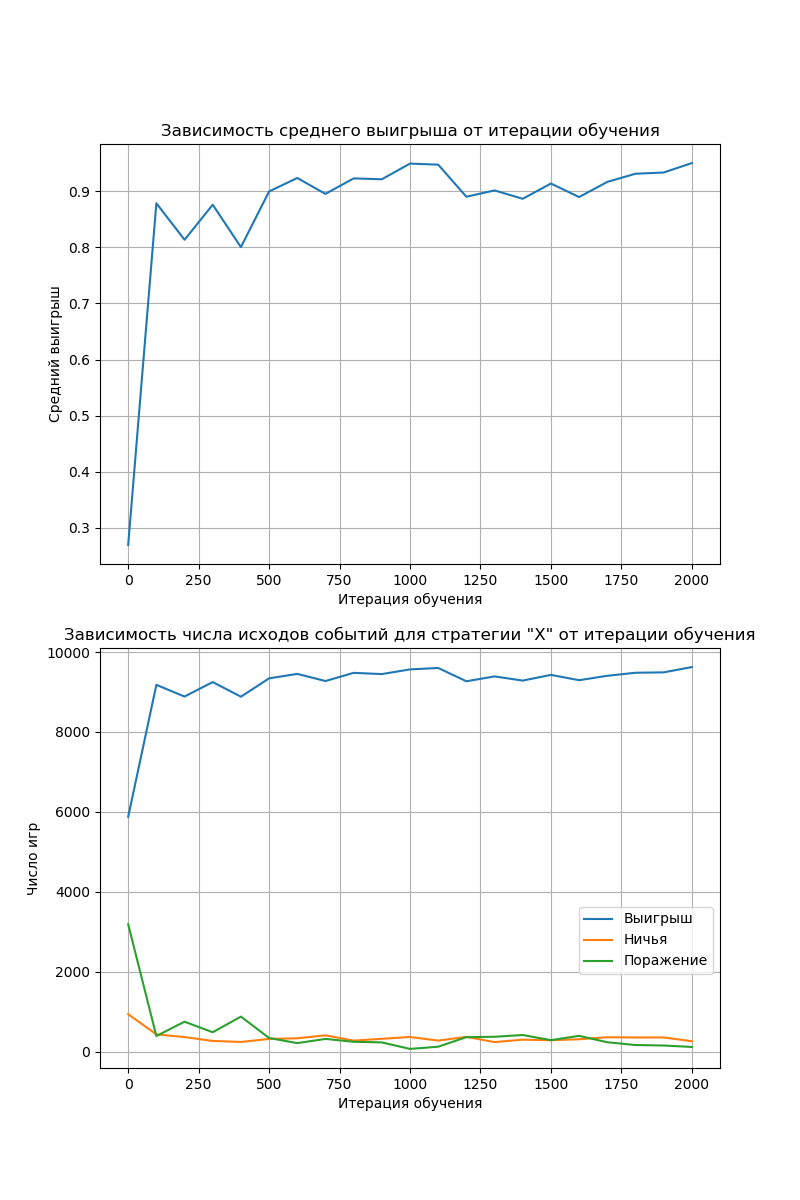

mean = 0.2691
Rounds 0, mean =0.2691, win = 5877, draw = 937, loose = 3186
mean = 0.8789
Rounds 100, mean =0.8789, win = 9179, draw = 431, loose = 390
mean = 0.8137
Rounds 200, mean =0.8137, win = 8886, draw = 365, loose = 749
mean = 0.8763
Rounds 300, mean =0.8763, win = 9248, draw = 267, loose = 485
mean = 0.8006
Rounds 400, mean =0.8006, win = 8882, draw = 242, loose = 876
mean = 0.9
Rounds 500, mean =0.9, win = 9341, draw = 318, loose = 341
mean = 0.924
Rounds 600, mean =0.924, win = 9453, draw = 334, loose = 213
mean = 0.8956
Rounds 700, mean =0.8956, win = 9274, draw = 408, loose = 318
mean = 0.9233
Rounds 800, mean =0.9233, win = 9479, draw = 275, loose = 246
mean = 0.9217
Rounds 900, mean =0.9217, win = 9448, draw = 321, loose = 231
mean = 0.9497
Rounds 1000, mean =0.9497, win = 9565, draw = 367, loose = 68
mean = 0.9478
Rounds 1100, mean =0.9478, win = 9601, draw = 276, loose = 123
mean = 0.8906
Rounds 1200, mean =0.8906, win = 9268, draw = 370, loose = 362
mean = 0.9018
Round

In [13]:
%matplotlib notebook
board_rows = 3
board_cols = 3
num_counts = 3

p1 = Player(board_rows, board_cols, batch_size=64, type_network="DQN")
p2 = Player(board_rows, board_cols, batch_size=64, type_network="DQN")
dqn = Solver(p1, p2, board_rows, board_cols, num_counts, TEST=False)
dqn.fit(episod_fit=2000, episod_validate=10000, delta_validate=100)

DuelingDQN

<IPython.core.display.Javascript object>


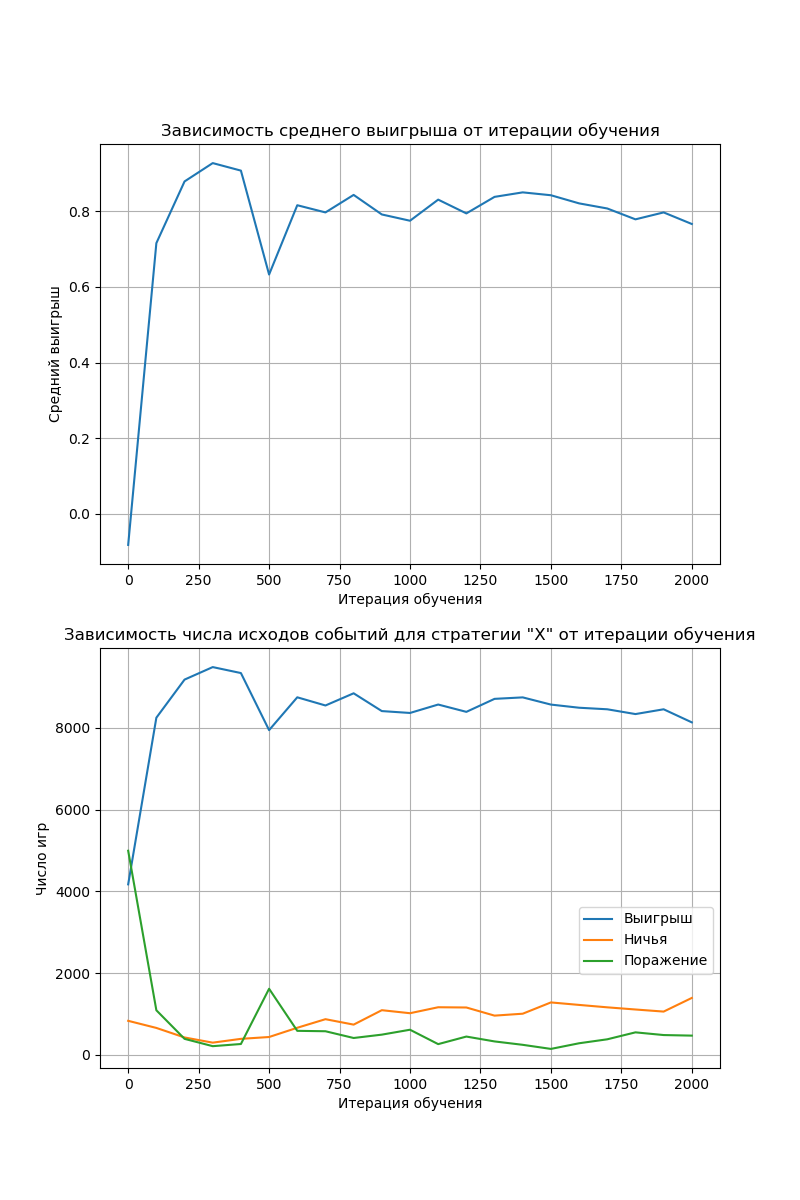

mean = -0.0822
Rounds 0, mean =-0.0822, win = 4172, draw = 834, loose = 4994
mean = 0.7156
Rounds 100, mean =0.7156, win = 8248, draw = 660, loose = 1092
mean = 0.8787
Rounds 200, mean =0.8787, win = 9180, draw = 427, loose = 393
mean = 0.9272
Rounds 300, mean =0.9272, win = 9486, draw = 300, loose = 214
mean = 0.9073
Rounds 400, mean =0.9073, win = 9340, draw = 393, loose = 267
mean = 0.6326
Rounds 500, mean =0.6326, win = 7944, draw = 438, loose = 1618
mean = 0.8158
Rounds 600, mean =0.8158, win = 8747, draw = 664, loose = 589
mean = 0.7968
Rounds 700, mean =0.7968, win = 8547, draw = 874, loose = 579
mean = 0.8431
Rounds 800, mean =0.8431, win = 8845, draw = 741, loose = 414
mean = 0.7914
Rounds 900, mean =0.7914, win = 8410, draw = 1094, loose = 496
mean = 0.7748
Rounds 1000, mean =0.7748, win = 8364, draw = 1020, loose = 616
mean = 0.8306
Rounds 1100, mean =0.8306, win = 8570, draw = 1166, loose = 264
mean = 0.7942
Rounds 1200, mean =0.7942, win = 8391, draw = 1160, loose = 449
me

In [14]:
%matplotlib notebook
board_rows = 3
board_cols = 3
num_counts = 3

p1 = Player(board_rows, board_cols, batch_size=64, type_network="DuelingDQN")
p2 = Player(board_rows, board_cols, batch_size=64, type_network="DuelingDQN")
dqn = Solver(p1, p2, board_rows, board_cols, num_counts, TEST=False)
dqn.fit(episod_fit=2000, episod_validate=10000, delta_validate=100)

# Игра 4x4

DQN

<IPython.core.display.Javascript object>


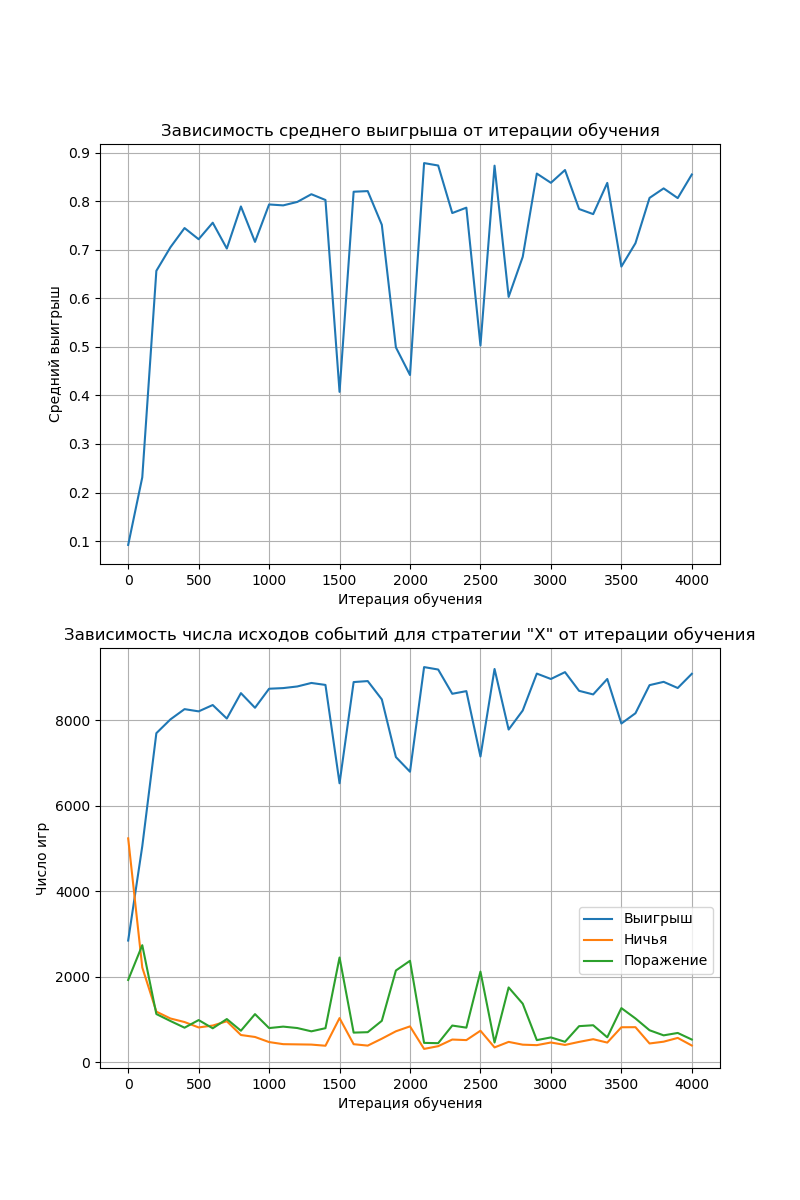

mean = 0.0921
Rounds 0, mean =0.0921, win = 2844, draw = 5233, loose = 1923
mean = 0.2313
Rounds 100, mean =0.2313, win = 5049, draw = 2215, loose = 2736
mean = 0.6566
Rounds 200, mean =0.6566, win = 7692, draw = 1182, loose = 1126
mean = 0.7052
Rounds 300, mean =0.7052, win = 8015, draw = 1022, loose = 963
mean = 0.7447
Rounds 400, mean =0.7447, win = 8254, draw = 939, loose = 807
mean = 0.7217
Rounds 500, mean =0.7217, win = 8202, draw = 813, loose = 985
mean = 0.7557
Rounds 600, mean =0.7557, win = 8350, draw = 857, loose = 793
mean = 0.7025
Rounds 700, mean =0.7025, win = 8034, draw = 957, loose = 1009
mean = 0.7892
Rounds 800, mean =0.7892, win = 8628, draw = 636, loose = 736
mean = 0.7162
Rounds 900, mean =0.7162, win = 8286, draw = 590, loose = 1124
mean = 0.7933
Rounds 1000, mean =0.7933, win = 8731, draw = 471, loose = 798
mean = 0.7914
Rounds 1100, mean =0.7914, win = 8746, draw = 422, loose = 832
mean = 0.7985
Rounds 1200, mean =0.7985, win = 8784, draw = 417, loose = 799
me

In [15]:
%matplotlib notebook
board_rows = 4
board_cols = 4
num_counts = 4

p1 = Player(board_rows, board_cols, batch_size=64, type_network="DQN")
p2 = Player(board_rows, board_cols, batch_size=64, type_network="DQN")
dqn = Solver(p1, p2, board_rows, board_cols, num_counts, TEST=False)
dqn.fit(episod_fit=4000, episod_validate=10000, delta_validate=100)

DuelingDQN

<IPython.core.display.Javascript object>


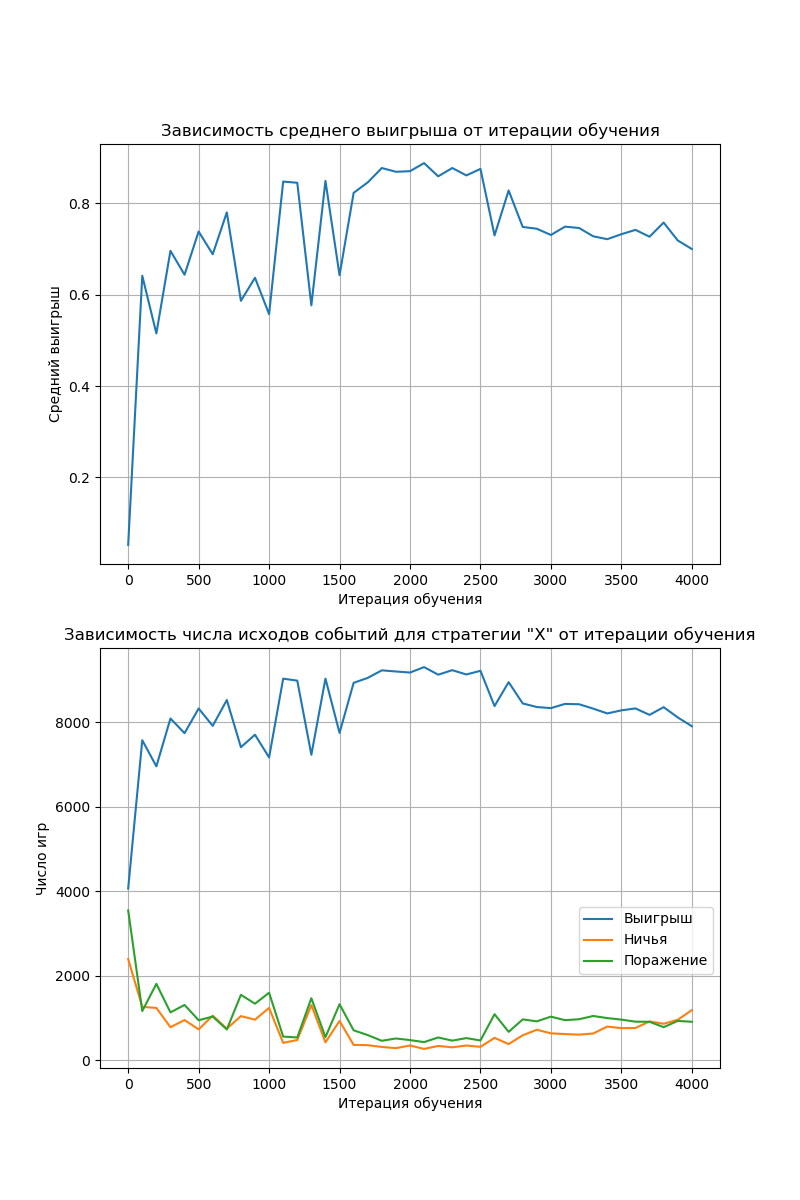

mean = 0.0519
Rounds 0, mean =0.0519, win = 4063, draw = 2393, loose = 3544
mean = 0.6415
Rounds 100, mean =0.6415, win = 7577, draw = 1261, loose = 1162
mean = 0.5152
Rounds 200, mean =0.5152, win = 6958, draw = 1236, loose = 1806
mean = 0.6961
Rounds 300, mean =0.6961, win = 8091, draw = 779, loose = 1130
mean = 0.6437
Rounds 400, mean =0.6437, win = 7744, draw = 949, loose = 1307
mean = 0.7384
Rounds 500, mean =0.7384, win = 8328, draw = 728, loose = 944
mean = 0.6886
Rounds 600, mean =0.6886, win = 7917, draw = 1052, loose = 1031
mean = 0.7803
Rounds 700, mean =0.7803, win = 8529, draw = 745, loose = 726
mean = 0.5866
Rounds 800, mean =0.5866, win = 7412, draw = 1042, loose = 1546
mean = 0.6371
Rounds 900, mean =0.6371, win = 7707, draw = 957, loose = 1336
mean = 0.5574
Rounds 1000, mean =0.5574, win = 7169, draw = 1236, loose = 1595
mean = 0.8478
Rounds 1100, mean =0.8478, win = 9035, draw = 408, loose = 557
mean = 0.8452
Rounds 1200, mean =0.8452, win = 8988, draw = 476, loose = 

In [16]:
%matplotlib notebook
board_rows = 4
board_cols = 4
num_counts = 4

p1 = Player(board_rows, board_cols, batch_size=64, type_network="DuelingDQN")
p2 = Player(board_rows, board_cols, batch_size=64, type_network="DuelingDQN")
dqn = Solver(p1, p2, board_rows, board_cols, num_counts, TEST=False)
dqn.fit(episod_fit=4000, episod_validate=10000, delta_validate=100)